In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from itertools import combinations
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import cross_validate, KFold

np.random.seed(42)

#### Introduction
This notebook will look at various ways of predicting the production of hitters in Out of the Park Baseball 22. The primary goal will be to predict a players weighted on-base average (wOBA). The goal is to not find the absolute best possible model, but to look at various ways to identify wOBA and get a general idea of how various attempts stack up to each other. 

There are three different methods employed in this notebook to predict a player's wOBA. The first method will be to take a player's rating and build a linear regression model directly against their wOBA from the data collected. The next two methods look at predicting the various events - walks, singles, doubles, triples and home runs - that are calculated as part of wOBA, and then taking those predicted rates and plugging them into the wOBA formula to get a players' wOBA. The first "rate based" method will predict each event on a per plate apperance basis.

The second of these "rate based" methods will utilize the theory that the OOTP engine does not decide a plate apperance on a pitch-by-pitch basis, but instead employs an order of operations (OOO) in determing the outcome of a plate appearance:
* The first step, it's theorized, is the engine determines if a walk has occured.
* Whether a strikeout has occured is the next step.
* This is followed by determining if the batter has hit a home run (the final of the "three true outcomes" in baseball).
* After the three true outcomes, whether or not a non-home run hit is determned.
* If there is a hit, whether or not it's for extra bases.
* And finally if it is an extra base hit, whether it was a double or a triple.

This notebook does not attempt to determine whether or not there is indeed an order of operations at play in the OOTP engine, just whether or not predicting events following the above order results in a better predictions than other methods employed.


#### The Data
Data for this notebook was collected utilizing build 34 for OOTP 22 during late March 2022. The game's base MLB start was utilized, with injuries, morale and fatigue reset. Every left-handed pitcher in the save was retired, resulting in a world where there are only right-handed batters. After these resets were completed, the AI was run on all teams to setup every team's pitching staff, lineups and depth charts.

All team's had their stadium set to the same one, with that stadium's park factors reset to 1.000 across the board. The ballparks average wind speed was set to 0 mph, with average wind direction set to Out to Center.

The simulation module was then utilized, forcing every team to play the 29 other teams a total of 2,430 games each. This resulted in every team playing a total of 70,470 games, or the equivalent of 433 seasons. Whether or not the simulation module is an adequate replacement for the game engine is up to debate, but looking at data generated through a season simulation with injuries, suspensions and position fatigure turned off shows minimal differences in the data outside of more variation from smaller sample sizes.

Once the simulation module run was completed, the generated data was matched up with the players ratings from the game that were dumped from the game into a MySQL database based on the player's ID. Since only right-handed pitchers exist in this world, only the player's batting ratings against right-handed pitchers was pulled, with the assumption a player's ratings against left-handed pitchers is irrelevant against right-handed pitchers. Additionally, only ratings that are available through the OOTP 22 user interface, or could be inferred easily without having to get a sample size for that particular player, were utilized. 

This means a player's BABIP rating is included since this rating can be inferred through other batting ratings like contact, strikeouts, and power, whereas a player's hit by pitch rating was left out since this is generally only inferred after a player has appeared in a certain number of games to generate a sample. Additionally ratings like bunting were also ignored. A player's contact rating was left out since this rating is a composite rating, primarily, of a player's BABIP and strikeout avoidance ratings, which are already included.

All switch hitters in the database were assigned to bat as lefties, since it is assumed the game would have them bat from the opposite side of the plate from the hand the pitcher throws with.

Finally a player's running speed was included since the engine uses this to determine the ratio of doubles to triples when calculating extra base hits.

##### Limitations of the Simulation Module
While the simulation module is generally an accrrate representation of the underlying game's engine, there are some drawbacks in utilizing it, especially when it comes to calculating wOBA. The reports that are genearated through the simulation module are lacking in certain baseball statistics, such as total plate apperances, intentional walks, sacrifices, and hit by pitches (hence why a player's hit by pitch rating is left out). 

While all of these statistics are apart of the wOBA calculation, they should not fundamentally effect the calculations that were done to get a player's wOBA. A player won't have their wOBA go from .390 to .310, or vice-versa, because these statistics are not available. 

Additionally wOBA is not a statistic generated through the simulation module reports, but we can calculate it ourselves from the stats that are generated. The weights for each event change from season to season in MLB, but without calculating linear weights and parsing the game logs that are generated, this is generally not an option. In order to calculate wOBA from the data that is available, the coefficients from [this Fangraph's article explaining wOBA were used](https://library.fangraphs.com/offense/woba/), and will be used later on in the notebook.

#### The Data
With the background on the goals of this notebook, and the setup for the test complete, it's time to dive into the data. The CSV for this notebook is included in the github repo and can be used to either verify or challenge my findings.

These first two code blocks just load the data, describe the shape and give a sense of how the data is structured. There are a total of 263 batters in our sample (only batters that had more than 3.1 "plate apperances" per game were included). Since plate apperances are not included in the simulation module reports, a PA is just the total number of at-bats and walks for a player.

In [2]:
df = pd.read_csv('OOTP22_Batting_2.csv', index_col='player_id')
df.shape

(263, 30)

In [3]:
df.head()

,G,AB,R,H,2B,3B,HR,RBI,TB,BB,...,running_ratings_baserunning,batting_ratings_vsr_contact,batting_ratings_vsr_babip,batting_ratings_vsr_gap,batting_ratings_vsr_power,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_misc_gb_hitter_type,batting_ratings_misc_fb_hitter_type,bats
player_id,,,,,,,,,,,,,,,,,,,,,
12,68596,244050,36719,50983,8720,733,15524,45693,107741,35447,...,106,76,83,76,170,149,65,3,2,2
15,70470,290504,44693,86065,17354,3612,11703,47112,145752,23770,...,176,160,134,158,120,96,126,2,2,1
16,70470,271746,47574,70659,14572,378,14188,46199,128551,43755,...,122,142,154,111,147,150,83,2,2,2
28,70470,252019,33916,68342,14429,365,8948,35823,110345,35094,...,88,120,144,105,111,131,87,2,2,1
42,59103,181051,19221,36730,6950,460,5981,19587,62543,14878,...,95,47,75,60,104,99,58,2,2,1


With the data now loaded, it's time to look at the various variables that will be used throughout the notebook, and convert a couple of them so they can be used by Scikit-Learn's machine learning implementation.

I've already mentioned some of the various ratings that will be used, but the code block below lists them all out explicitly. Since a batters ground and flyball tendancies, as well as the side of the plate they bat from, are listed numerically, they need to be converted to categorical variables for Scikit-Learn to properly use them. In R, we could just convert these to factors and be done with it, but we need to take an extra step in Pandas and use the get_dummies method first.

After this is completed, the listed variables and how they will be utilized in this notebook is shown below.

In [4]:
variables = df[['running_ratings_speed',
       'batting_ratings_vsr_babip', 'batting_ratings_vsr_gap',
       'batting_ratings_vsr_power', 'batting_ratings_vsr_eye',
       'batting_ratings_vsr_strikeouts', 'batting_ratings_misc_gb_hitter_type',
       'batting_ratings_misc_fb_hitter_type', 'bats']]

variables[['batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type', 'bats']] = variables[['batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type', 'bats']].astype('category')
variables = pd.get_dummies(variables)
variables.head()

c:\program files\python37\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,running_ratings_speed,batting_ratings_vsr_babip,batting_ratings_vsr_gap,batting_ratings_vsr_power,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_misc_gb_hitter_type_0,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,bats_1,bats_2
player_id,,,,,,,,,,,,,,,
12,65,83,76,170,149,65,0,0,0,1,0,0,1,0,1
15,169,134,158,120,96,126,0,0,1,0,0,0,1,1,0
16,63,154,111,147,150,83,0,0,1,0,0,0,1,0,1
28,53,144,105,111,131,87,0,0,1,0,0,0,1,1,0
42,24,75,60,104,99,58,0,0,1,0,0,0,1,1,0


#### Method One: Predicting wOBA
With the data preprocessing and setup steps completed, it's time to move into actually predicting wOBA from the player's ratings. For this part, our target is wOBA, and we're going to build a model on all the variables using Scikit-Learn's Linear Regression model. Again, this notebook is not trying to find the absolute best model, so things like Ridge, Lasso, ElasticNet regression, or other models, is beyond the scope for what I am doing.

I want to touch on a couple of concepts that will be introduced in the next code block, and used throughout before diving directly in the model building. The first of these is K-Fold. This is a process used in testing models to help determine the true predictive ability of any model when looking at new data. This notebook will be utilizing 10 different folds, which means the data is split up into 10 equal parts (26 batters per fold). When a model is built, nine of those folds are used to build the model, and then the 10th fold that was left out is used as the validation (scoring) fold. This process repeats itself an additional nine times until every fold has been used as a validation set, and then the mean scores across all ten iterations are used to determine the model's predictive ability.

The second concept is recursive feature elimination. What this process does is will build models using all the variables in the dataset, and then iteratively remove one of those variables at a time, and then creating a new model on that smaller feature set. At the end of this process, the model with the best score - I'll be using mean-squared error - and the features (variables) used to produce that best model will be shown. This helps us determine whether a variable is beneficial or not. 

In this next code block, our target is set to the player's wOBA, a linear regression implementation is setup. Additionally the splitter with 10 folds, and the data shuffled before split, is also created. 

The first iteration runs through all the variables in the data set, with the mean squared error and r2 scores presented.

In [5]:
target = 'wOBA'
lr = linear_model.LinearRegression()
splitter = KFold(n_splits=10, shuffle=True)

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.8959598226102521
-0.00005794


This next cell demonstrates the recursive feature elmination process, with the variables used in the "best" model listed. This process could result in different results being displayed if the code block is run more than once due to randmoness introduced when the data set is shuffled. For example, if I ran this next code block 10 times, running speed could be a part of the best model in perhapds four of them, while it's removed in six. This is just down to that randomness when splitting the folds. As long as the notebook is run once the entire way through, the results should be duplicated as the seed used for splitting is set in the first code block.

In this instance, running speed was identified as not a variable used in the "best" model from the available feature set. It should be pointed out that just because a variable was included in the recursive feature elminiation process, it could be so insignifant that it really has no impact on the overall score. This is probably what's happening with all of the gb and fb hitter types (performing this process in R, or using SciPy to get the p-value for each variable shows this to be true). 

In [6]:
selector = RFECV(lr, cv=splitter, scoring='neg_mean_squared_error')
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': True,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

With running speed removed from the feature set, both the mean squared error and r2 scores for the linear regression model are slightly better.

In [7]:
scores = cross_validate(lr, variables.loc[:, variables.columns[1:]], df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9057482054482129
-0.00005681


This next block then creates a model using all of the data (not split into 10 folds), and shows the relative coefficients for each variable used to build that model. There is also a plot showing the predicted wOBA for each player against their "true" wOBA produced from the simulation module.

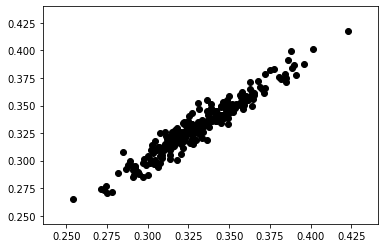

{'batting_ratings_vsr_babip': 0.0005525485350374216,
 'batting_ratings_vsr_gap': 0.00014142881235553644,
 'batting_ratings_vsr_power': 0.0006185747969998887,
 'batting_ratings_vsr_eye': 0.0003220580635161239,
 'batting_ratings_vsr_strikeouts': 0.0005213731487251429,
 'batting_ratings_misc_gb_hitter_type_0': 0.003127810261421756,
 'batting_ratings_misc_gb_hitter_type_1': 0.0022015444115183486,
 'batting_ratings_misc_gb_hitter_type_2': 0.0002991946344271527,
 'batting_ratings_misc_gb_hitter_type_3': -0.005628549307367259,
 'batting_ratings_misc_fb_hitter_type_0': -0.00012639122278803873,
 'batting_ratings_misc_fb_hitter_type_1': 0.001782735952889461,
 'batting_ratings_misc_fb_hitter_type_2': -0.0016563447301014178,
 'bats_1': 0.004266419113494833,
 'bats_2': -0.004266419113494833}

In [8]:
lr.fit(variables.loc[:, variables.columns[1:]], df[target])
df['PRED_WOBA'] = lr.predict(variables.loc[:, variables.columns[1:]])

plt.scatter(df['wOBA'], df['PRED_WOBA'], color='black')
plt.show()

dict(zip(variables.loc[:, variables.columns[1:]], lr.coef_))

### Methods Two and Three
##### Predicting Walks
The first method of just taking a player's ratings and then predicting their wOBA directly is pretty straight-forward. Since the next two methods are looking at predicting the underlying events for wOBA, I'll be working through them both at the same time. Anytime there's OOO in a code block, or referenced, that is an indicator for method three which is predicting events on the order of operations theory.

Since there's no difference in the rate at which a player walks between methods two and three (both are on a per plate appearance rate), there's no reason to create a OOO rate for walks.

The first step in this process will be predicting a player's walk rate. Generally each rating corresponds to a single event, and is the primary rating for that event, though other ratings can have an impact. 

In the below code block, the number of plate apperances for each player is calculated by adding their at-bats and total walks. Again, this is not every plate appearance a player would normally have, but due to limitations in the simulation module, it's the best we can get without parsing game logs. A plot comparing a player's eye rating on their walk rate is then shown.

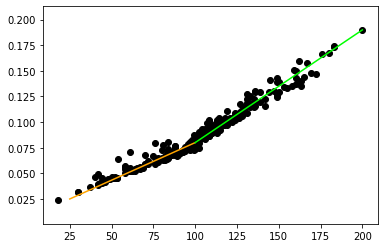

In [9]:
df['PA'] = df['BB'] + df['AB']
df['BB_RATE'] = df['BB'] / df['PA']

plt.scatter(df['batting_ratings_vsr_eye'], df['BB_RATE'], color='black')
x1, y1 = [25, 100], [0.025, 0.08]
x2, y2 = [100, 200], [.08, .19]
plt.plot(x1,y1, color='orange')
plt.plot(x2,y2, color='lime')
plt.show()

When visualizing the data this way, it's clear that there are two different models that OOTP uses when calculating a player's walk rate: one for a player with an eye rating below 100 (50 on a 20-80 scale), and one for player's with an eye rating above 100. I included a rough line on the graph to help differentiate between the two apparent models.

For the time being, I'm going to roll with a single model in predicting walk rate before buidling two separate ones to for comparisions sake.

In [10]:
target = 'BB_RATE'

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9518413712821413
-0.00004039


In [11]:
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': False,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': False,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

Feature eleimination shows that ratings we would assume to not be important to a player's ability to draw a walk are indeed removed. In this instance strikeouts is also shown to be removed, but depending on randomness alerady described, it could potentially be kept in this process. For our purposes, we'll remove it.

In [12]:
walk_variables = variables.loc[:, ['batting_ratings_vsr_power',
                                     'batting_ratings_vsr_eye',
                                     'batting_ratings_misc_gb_hitter_type_0',
                                     'batting_ratings_misc_gb_hitter_type_1',
                                     'batting_ratings_misc_gb_hitter_type_2',
                                     'batting_ratings_misc_gb_hitter_type_3',
                                     'batting_ratings_misc_fb_hitter_type_0',
                                     'batting_ratings_misc_fb_hitter_type_1',
                                     'batting_ratings_misc_fb_hitter_type_2',
                                     'bats_1',
                                     'bats_2']
                                    ]

scores = cross_validate(lr, walk_variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9517869555584211
-0.00003893


Mean squared error didn't improve, but our r2 score did slightly. I'll fit a model on the full data set below and print out the mean squared error for reference in a little bit.

In [13]:
lr.fit(walk_variables, df[target])
print('{:.8f}'.format(float(mean_squared_error(lr.predict(walk_variables), df[target]))))
print(r2_score(lr.predict(walk_variables), df[target]))

0.00003648
0.9549390955190373


This next plot confirms the suspicions that using a single model to predict walk rate is indeed the wrong approach. This is not quite a residuals plot that would normally be presented, but a residuals plot against the player's eye rating. Ideally there would not be any "form" to the data, but the plot shows there is indeed structure as a player's walk rate is more likely to have a higher predicted result as the eye rating gets closer to 100.

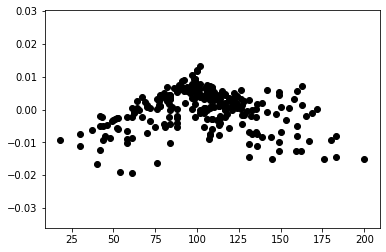

In [14]:
plt.scatter(df['batting_ratings_vsr_eye'], lr.predict(walk_variables) - df[target], color='black')

The qq plot below confirms this. Ideally all dots would be along the red line, but the dots towards the end are below, while the ones in the middle are above.

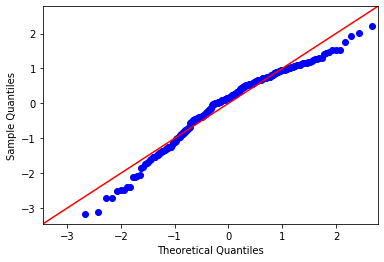

In [15]:
residuals = lr.predict(walk_variables) - df[target]

fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

Based on the plot above, it's readily apparent there are two separate models the game uses for walk rate, one below 100 eye and one above 100 eye. We'll use the same variables identified in the feature elimination process and create models for both scenarios.

In [16]:
low_eye = linear_model.LinearRegression()
low_eye.fit(walk_variables.loc[walk_variables['batting_ratings_vsr_eye'] < 100, :], df.loc[df['batting_ratings_vsr_eye'] < 100, 'BB_RATE'])

high_eye = linear_model.LinearRegression()
high_eye.fit(walk_variables.loc[walk_variables['batting_ratings_vsr_eye'] >= 100, :], df.loc[df['batting_ratings_vsr_eye'] >= 100, 'BB_RATE'])

LinearRegression()

This next section gets into the heart of how I'll be testing methods two and three. I could just look at the difference in the predicted rate an event happens and the rate that event happened in the data. However, because we're talking percentages, the numbers being presented could be obfuscated. To help show the results in a way most people would be readily able to understand, I'll be using a simulated season of 680 plate appearances for each player. This equates to roughly 4.2 plate apperances per game in a 162 game season. This 4.2 plate apperances for game rate came from [this Fangraphs article.](https://fantasy.fangraphs.com/buying-generic-plate-appearances-by-lineup-spot/)

In the code block below, I create a predictions DataFrame with the true walk rate fromthe data, and the player's predicted walk rate from the two models that were just created. Before I convert those predicted walk rates to a predicted number of walks in our theoretical season, let's compare the two model approach that was just fitted versus the single model approach. 

The mean squared error from the two model approach is better than the one model approach, while the r2 score bumps up from .95 to .97.

In [17]:
predictions = pd.DataFrame()
predictions['TRUE_BB'] = df['BB_RATE']
predictions['PRED_BB'] = 0
predictions['EYE'] = walk_variables['batting_ratings_vsr_eye']
predictions.loc[predictions['EYE'] < 100 , 'PRED_BB'] = low_eye.predict(walk_variables.loc[walk_variables['batting_ratings_vsr_eye'] < 100, :])
predictions.loc[predictions['EYE'] >= 100 , 'PRED_BB'] = high_eye.predict(walk_variables.loc[walk_variables['batting_ratings_vsr_eye'] >= 100, :])
predictions.drop('EYE', axis=1, inplace=True)

print('{:.8f}'.format(float(mean_squared_error(predictions['PRED_BB'], df[target]))))
print(r2_score(predictions['PRED_BB'], df[target]))

0.00002054
0.975118998201809


At this point one could get into more feature engineering to try and deal with the tailing, perhaps scaling certain ratings, but I'm going to say it's good enough and move on. This next block just takes that predicted rate and multiplies it by our 680 plate apperances in our theoretical season. A plot of the difference between the number of walks in our predicted season compared to what the simulation module is also shown. 

As can be see in the plot (they show the same thing, just different ways), we're about +/- 2 walks off for the most part over the course a season. 

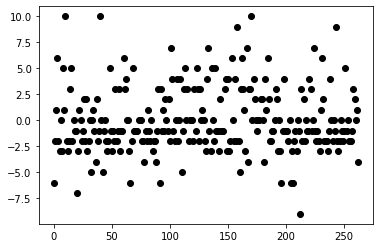

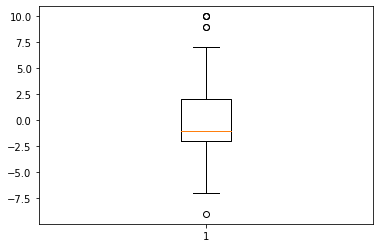

In [19]:
season_pa = 680
predictions['TRUE_BB'] = np.round(predictions['TRUE_BB'] * season_pa, 0).astype('int')
predictions['PRED_BB'] = np.round(predictions['PRED_BB'] * season_pa, 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['TRUE_BB'] - predictions['PRED_BB'], color='black')
plt.show()

plt.boxplot(predictions['TRUE_BB'] - predictions['PRED_BB'])
plt.show()

##### Predicting Strikeouts

This is where the two methods will start to diverge. Method two again doesn't assume there's an "order" to how a plate apperance is determined, whereas method three assumes there is. 

For method two, our strikeout rate is simply the number of strikeouts divided by the total number of plate apperances.

For method three, the strikeout rate is the number of strikeouts divided by the number at-bats (not plate apperances because our plate apperance calculation just used at-bats plus walks. Subtracting walks from plate appearances just gets us back to at-bats).

Below is a plot showing the relationship between the strikeouts rating and the per plate apperance strikeout rate. I've included three rough lines that seem to indicate there are three breakpoints for strikeouts.

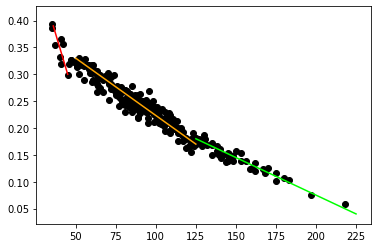

In [20]:
df['K_RATE'] = df['K'] / df['PA']
df['OOO_K_RATE'] = df['K'] / df['AB']
plt.scatter(df['batting_ratings_vsr_strikeouts'], df['K_RATE'], color='black')
x1, y1 = [36, 45], [0.39, 0.30]
x2, y2 = [50, 125], [.33, .17]
x3, y3 = [125, 225], [.18, .04]
plt.plot(x1,y1, color='red')
plt.plot(x2,y2, color='orange')
plt.plot(x3,y3, color='lime')
plt.show()

I'm going to breeze through these next couple of code blocks because they're repetitive to what was just done for walks. The first just gets baseline scores for a single strikeout model, the second removes features (only running and babip are eliminated), and then the third plots a full model with those variables against the strikeout rating, and gets the scores to compare to a three model approach.

In [21]:
target = 'K_RATE'

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9740935956523862
-0.00008422


In [22]:
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

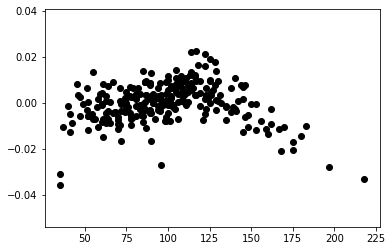

0.00007430
0.9778422604473003


In [23]:
strikeout_variables = variables.loc[:, ['batting_ratings_vsr_gap',
                    'batting_ratings_vsr_power',
                    'batting_ratings_vsr_eye',
                    'batting_ratings_vsr_strikeouts',
                    'batting_ratings_misc_gb_hitter_type_0',
                    'batting_ratings_misc_gb_hitter_type_1',
                    'batting_ratings_misc_gb_hitter_type_2',
                    'batting_ratings_misc_gb_hitter_type_3',
                    'batting_ratings_misc_fb_hitter_type_0',
                    'batting_ratings_misc_fb_hitter_type_1',
                    'batting_ratings_misc_fb_hitter_type_2',
                    'bats_1',
                    'bats_2'  
                    ]]

plt.scatter(df['batting_ratings_vsr_strikeouts'], lr.fit(strikeout_variables, df[target]).predict(strikeout_variables) - df[target], color='black')
plt.show()

print('{:.8f}'.format(float(mean_squared_error(lr.predict(strikeout_variables), df[target]))))
print(r2_score(lr.predict(strikeout_variables), df[target]))

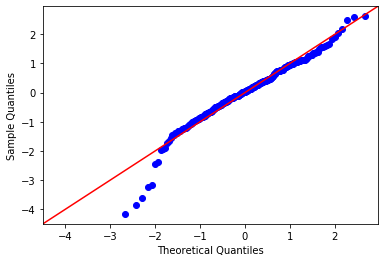

In [24]:
residuals = lr.predict(strikeout_variables) - df[target]

fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

Pretty much the same results from the single walk model. These next two blocks just create three separate models, one below 50 strikeouts, one between 50 and 125, and then one greater than 125. Then the mean squared error and r2 scores for our three model approach is shown before the predictions are converted to our seasonal bassis.

In [25]:
low_k = linear_model.LinearRegression()
low_k.fit(variables.loc[variables['batting_ratings_vsr_strikeouts'] < 50, :], df.loc[df['batting_ratings_vsr_strikeouts'] < 50, target])
mid_k = linear_model.LinearRegression()
mid_k.fit(variables.loc[(variables['batting_ratings_vsr_strikeouts'] >= 50) & (variables['batting_ratings_vsr_strikeouts'] < 125), :], df.loc[(df['batting_ratings_vsr_strikeouts'] > 50) & (df['batting_ratings_vsr_strikeouts'] < 125), target])
high_k = linear_model.LinearRegression()
high_k.fit(variables.loc[variables['batting_ratings_vsr_strikeouts'] >= 125, :], df.loc[df['batting_ratings_vsr_strikeouts'] >= 125, target])

LinearRegression()

In [32]:
predictions['TRUE_K'] = df['K_RATE']
predictions['PRED_K'] = 0
predictions['K'] = variables['batting_ratings_vsr_strikeouts']
predictions.loc[predictions['K'] < 50, 'PRED_K'] = low_k.predict(variables.loc[variables['batting_ratings_vsr_strikeouts'] < 50, :])
predictions.loc[predictions['K'] >= 125, 'PRED_K'] = high_k.predict(variables.loc[variables['batting_ratings_vsr_strikeouts'] >= 125, :])
predictions.loc[(predictions['K'] >= 50) & (predictions['K'] < 125), 'PRED_K'] = mid_k.predict(variables.loc[(variables['batting_ratings_vsr_strikeouts'] >= 50) & (variables['batting_ratings_vsr_strikeouts'] < 125), :])

print('{:.8f}'.format(float(mean_squared_error(predictions['PRED_K'], df[target]))))
print(r2_score(predictions['PRED_K'], df[target]))

0.00003271
0.9903660546702505


The three model approach seems to be the right approach, with an r2 of .99 compared to .97, and the mean squared error is also been reduced from .00007 to .00003. The enxt two blocks just show some diagnostic plots, with the second block showing that when we're wrong, we're wrong by +/- 2.5 strikeouts most of the time, similar to our walks predictions.

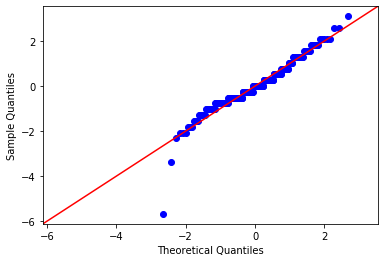

In [35]:
residuals = predictions['PRED_K'] - predictions['TRUE_K']

fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

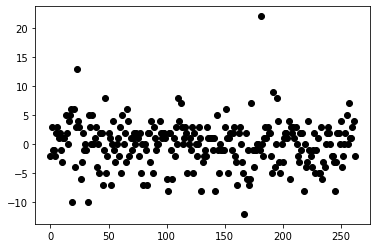

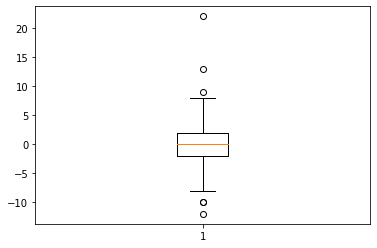

14.98098859
0.9904632178418357


In [34]:
predictions['TRUE_K'] = np.round(predictions['TRUE_K'] * season_pa, 0).astype('int')
predictions['PRED_K'] = np.round(predictions['PRED_K'] * season_pa, 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['TRUE_K'] - predictions['PRED_K'], color='black')
plt.show()

plt.boxplot(predictions['TRUE_K'] - predictions['PRED_K'])
plt.show()

I'll skip over some of the same steps that were done for the per plate apperance approach for strikeouts, other than to confirm the same breaks area apparent when calculating k-rate on an at-bat rate. Additioanally a look at the relevant variables is done just to confirm the same variables from the previous method are still applicable.

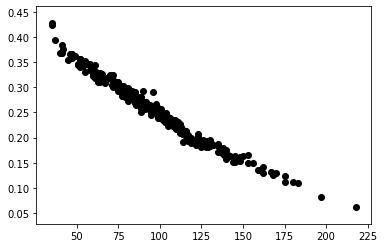

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

In [40]:
plt.scatter(df['batting_ratings_vsr_strikeouts'], df['OOO_K_RATE'], color='black')
plt.show()

target = 'OOO_K_RATE'
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

In [41]:
low_k = linear_model.LinearRegression()
low_k.fit(strikeout_variables.loc[variables['batting_ratings_vsr_strikeouts'] < 50, :], df.loc[df['batting_ratings_vsr_strikeouts'] < 50, target])
mid_k = linear_model.LinearRegression()
mid_k.fit(strikeout_variables.loc[(variables['batting_ratings_vsr_strikeouts'] >= 50) & (strikeout_variables['batting_ratings_vsr_strikeouts'] < 125), :], df.loc[(df['batting_ratings_vsr_strikeouts'] > 50) & (df['batting_ratings_vsr_strikeouts'] < 125), target])
high_k = linear_model.LinearRegression()
high_k.fit(strikeout_variables.loc[variables['batting_ratings_vsr_strikeouts'] >= 125, :], df.loc[df['batting_ratings_vsr_strikeouts'] >= 125, target])

LinearRegression()

Since we confirmed in the previous approach that creating three separate models based on the player's strikeout rating was the more accurate approach, there's no reason to compare the at-bat rate to that original model. We'll skip directly to the plots showing the difference between predicted versus actual rates. For our theoretical season, we take our 680 total plate apperances, and subtract the true walks (TRUE_BB), and predicted walks (PRED_BB) for each to get the number of opportunities available for our players.

In [46]:
predictions['OOO_TRUE_K'] = np.round(df['OOO_K_RATE'] * (season_pa - predictions['TRUE_BB']), 0).astype('int')
predictions['OOO_PRED_K'] = 0
predictions['K'] = variables['batting_ratings_vsr_strikeouts']
predictions.loc[predictions['K'] < 50, 'OOO_PRED_K'] = low_k.predict(strikeout_variables.loc[variables['batting_ratings_vsr_strikeouts'] < 50, :])
predictions.loc[predictions['K'] >= 125, 'OOO_PRED_K'] = high_k.predict(strikeout_variables.loc[variables['batting_ratings_vsr_strikeouts'] >= 125, :])
predictions.loc[(predictions['K'] >= 50) & (predictions['K'] < 125), 'OOO_PRED_K'] = mid_k.predict(strikeout_variables.loc[(variables['batting_ratings_vsr_strikeouts'] >= 50) & (variables['batting_ratings_vsr_strikeouts'] < 125), :])

predictions.drop('K', axis=1, inplace=True)

predictions['OOO_PRED_K'] = np.round(predictions['OOO_PRED_K'] * (season_pa - predictions['PRED_BB']), 0).astype('int')


The below plot compares the residuals (how far off each method is when predicting strikeouts), and there's no readily observable difference between the two methods when comparing strikeouts. Below are printounts of each method's mean squared error and r2 score. Both are pretty comparable, with the order of operations method slightly ahead.

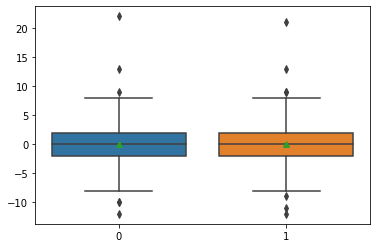

In [56]:
sns.boxplot(
    data=[predictions['TRUE_K'] - predictions['PRED_K'], predictions['OOO_TRUE_K'] - predictions['OOO_PRED_K']],
    showmeans=True
)
plt.show()

In [57]:
print(mean_squared_error(predictions['OOO_PRED_K'], predictions['OOO_TRUE_K']))
print(mean_squared_error(predictions['PRED_K'], predictions['TRUE_K']))

print(r2_score(predictions['OOO_PRED_K'], predictions['OOO_TRUE_K']))
print(r2_score(predictions['PRED_K'], predictions['TRUE_K']))

13.798479087452472
14.980988593155894
0.9911860604359837
0.9904632178418357


##### Home Runs
With strikeouts now covered, it's time to look at home run rates. This is where the first real divergence between the two methods really starts to take place. For the second method, it's again just a straight home run per plate appearance rate, whereas the order of operations denominator is now significantly reduced in our theoretical season having both walks and strikeouts subtracted from it.

In the code block below I just set the various home run rate targets we'll be looking at, and then plotting power against the per plate apperance home run rate to identify if there are multiple models (shocker, there are).

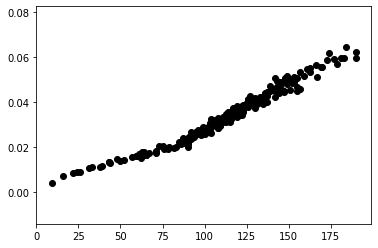

In [58]:
df['HR_RATE'] = df['HR'] / df['PA']
df['OOO_HR_RATE'] = df['HR'] / (df['AB'] - df['K'])
plt.scatter(df['batting_ratings_vsr_power'], df['HR_RATE'], color='black')
plt.show()

Since it's already been established at this point that multiple models are better than a single one, I'll skip that step and look at the relavant variables to include in the two separate ones that will be used for home runs.

In [59]:
target = 'HR_RATE'
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

In [64]:
homerun_variables = variables.loc[:, ['batting_ratings_vsr_gap',
                    'batting_ratings_vsr_power',
                    'batting_ratings_vsr_eye',
                    'batting_ratings_vsr_strikeouts',
                    'batting_ratings_misc_gb_hitter_type_0',
                    'batting_ratings_misc_gb_hitter_type_1',
                    'batting_ratings_misc_gb_hitter_type_2',
                    'batting_ratings_misc_gb_hitter_type_3',
                    'batting_ratings_misc_fb_hitter_type_0',
                    'batting_ratings_misc_fb_hitter_type_1',
                    'batting_ratings_misc_fb_hitter_type_2',
                    'bats_1',
                    'bats_2'  
                    ]]



low_pow = linear_model.LinearRegression()
low_pow.fit(homerun_variables.loc[homerun_variables['batting_ratings_vsr_power'] < 90, :], df.loc[df['batting_ratings_vsr_power'] < 90, target])

high_pow = linear_model.LinearRegression()
high_pow.fit(homerun_variables.loc[homerun_variables['batting_ratings_vsr_power'] >= 90, :], df.loc[df['batting_ratings_vsr_power'] >= 90, target])

LinearRegression()

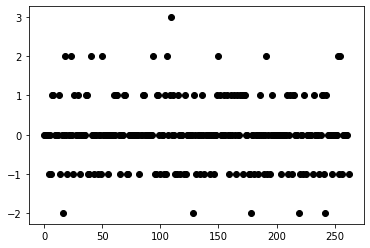

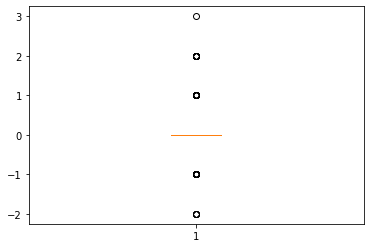

In [69]:
predictions['TRUE_HR'] = np.round(df['HR_RATE'] * season_pa, 0).astype('int')
predictions['PRED_HR'] = 0
predictions['HR'] = variables['batting_ratings_vsr_power']
predictions.loc[predictions['HR'] < 90, 'PRED_HR'] = np.round(low_pow.predict(homerun_variables.loc[variables['batting_ratings_vsr_power'] < 90, :]) * season_pa, 0).astype('int')
predictions.loc[predictions['HR'] >= 90, 'PRED_HR'] = np.round(high_pow.predict(homerun_variables.loc[variables['batting_ratings_vsr_power'] >= 90, :]) * season_pa, 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['PRED_HR'] - predictions['TRUE_HR'], color='black')
plt.show()

plt.boxplot(predictions['PRED_HR'] - predictions['TRUE_HR'])
plt.show()

For most players, the predictions are spot on, and when they're off, they're off by a single home run.

Next up is the order of operations method. Again, the rate for this subtracts strikeouts from the player's at bats in the sim. For the predictions part, the player's predicted walks and strikeouts will be subtracted to get the number of opportunities available.

First up is to confirm there is again two models when looking at home run rate this way, confirming that the same variables should be used, and then building those two models.

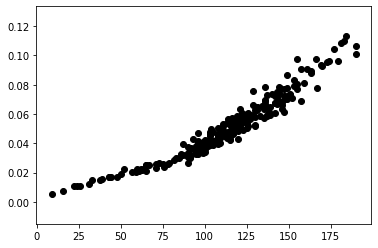

In [70]:
plt.scatter(df['batting_ratings_vsr_power'], df['OOO_HR_RATE'], color='black')
plt.show()

In [71]:
target = 'OOO_HR_RATE'
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': False,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

This is the first divergence in the variables used to build a model, with a player's eye rating removed. So we'll remove it and build the low and high variations of the home run model.

In [72]:
ooo_homerun_variables = variables.loc[:, ['batting_ratings_vsr_gap',
                    'batting_ratings_vsr_power',
                    'batting_ratings_vsr_strikeouts',
                    'batting_ratings_misc_gb_hitter_type_0',
                    'batting_ratings_misc_gb_hitter_type_1',
                    'batting_ratings_misc_gb_hitter_type_2',
                    'batting_ratings_misc_gb_hitter_type_3',
                    'batting_ratings_misc_fb_hitter_type_0',
                    'batting_ratings_misc_fb_hitter_type_1',
                    'batting_ratings_misc_fb_hitter_type_2',
                    'bats_1',
                    'bats_2'  
                    ]]

low_pow = linear_model.LinearRegression()
low_pow.fit(ooo_homerun_variables.loc[ooo_homerun_variables['batting_ratings_vsr_power'] < 90, :], df.loc[df['batting_ratings_vsr_power'] < 90, target])

high_pow = linear_model.LinearRegression()
high_pow.fit(ooo_homerun_variables.loc[ooo_homerun_variables['batting_ratings_vsr_power'] >= 90, :], df.loc[df['batting_ratings_vsr_power'] >= 90, target])

LinearRegression()

In [76]:
predictions['OOO_TRUE_HR'] = np.round(df['OOO_HR_RATE'] * (season_pa - predictions['PRED_BB'] - predictions['OOO_PRED_K']), 0).astype('int')
predictions['OOO_PRED_HR'] = 0
predictions['HR'] = variables['batting_ratings_vsr_power']
predictions.loc[predictions['HR'] < 90, 'OOO_PRED_HR'] = low_pow.predict(ooo_homerun_variables.loc[ooo_homerun_variables['batting_ratings_vsr_power'] < 90, :])
predictions.loc[predictions['HR'] >= 90, 'OOO_PRED_HR'] = high_pow.predict(ooo_homerun_variables.loc[ooo_homerun_variables['batting_ratings_vsr_power'] >= 90, :])
predictions['OOO_PRED_HR'] = np.round(predictions['OOO_PRED_HR'] * (season_pa - predictions['PRED_BB'] - predictions['OOO_PRED_K']),0).astype('int')

predictions.drop('HR', axis=1, inplace=True)

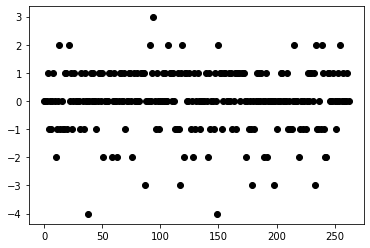

In [80]:
plt.scatter(predictions.reset_index().index, predictions['OOO_PRED_HR'] - predictions['OOO_TRUE_HR'], color='black')
plt.show()

This method of predicting home runs, while still close, is slightly less accurate compared to the per plate apperance rate. Again, it's around a single home run off, so not the end of the world.

Both mean squared error and r2 for the order of operations method are slightly larger.

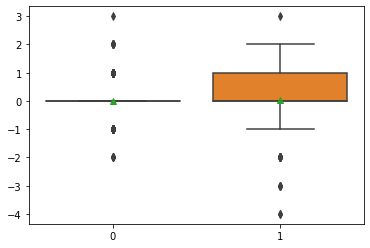

In [81]:
sns.boxplot(
    data=[predictions['PRED_HR'] - predictions['TRUE_HR'], predictions['OOO_PRED_HR'] - predictions['OOO_TRUE_HR']],
    showmeans=True
)
plt.show()

In [82]:
print(mean_squared_error(predictions['OOO_PRED_HR'], predictions['OOO_TRUE_HR']))
print(mean_squared_error(predictions['PRED_HR'], predictions['TRUE_HR']))

print(r2_score(predictions['OOO_PRED_HR'], predictions['OOO_TRUE_HR']))
print(r2_score(predictions['PRED_HR'], predictions['TRUE_HR']))

1.129277566539924
0.6387832699619772
0.9825671627667395
0.9900526410346118


##### Hits
Moving on to predicting hits. The order of operations method basically is just predicting a player's BABIP, 

When plotting BABIP against both hits per plate apperance, or BABIP in the order of operations method, there's no discernable "break" like there was in the three previous statistics.

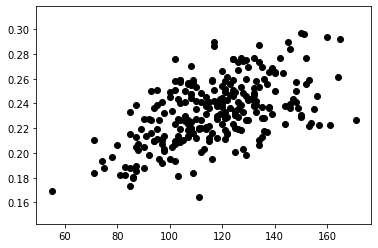

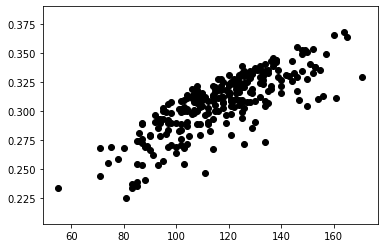

In [84]:
df['H_RATE'] = df['H'] / df['PA']
df['OOO_H_RATE'] = (df['H'] - df['HR']) / (df['AB'] - df['K'] - df['HR'])

plt.scatter(df['batting_ratings_vsr_babip'], df['H_RATE'], color='black')
plt.show()
plt.scatter(df['batting_ratings_vsr_babip'], df['OOO_H_RATE'], color='black')
plt.show()

Feature elimination does not eliminate any of the variables (shown below), so we'll breeze right into making predictions on a single model with all the variables, and then seeing how it performed.

In [87]:
target = 'H_RATE'

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9278868334746594
-0.00004378


In [88]:
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': True,
 'batting_ratings_vsr_babip': True,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

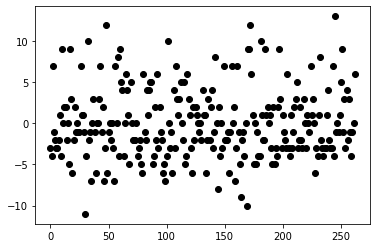

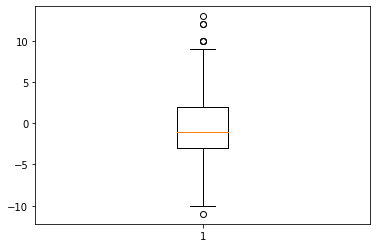

In [91]:
predictions['TRUE_H'] = np.round(df['H_RATE'] * season_pa, 0).astype('int')
predictions['PRED_H'] = np.round(lr.predict(variables) * season_pa, 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['PRED_H'] - predictions['TRUE_H'], color='black')
plt.show()

plt.boxplot(predictions['PRED_H'] - predictions['TRUE_H'])
plt.show()

It's pretty good, with most predictions within +/- 3 hits over our theoretical season.

Onto the order of operations method.

In [92]:
target = 'OOO_H_RATE'

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.8552042293717973
-0.00009609


In [93]:
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': False,
 'batting_ratings_vsr_babip': True,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': False,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

When going through the cross validation process, the r2 score for the order of operations method using all variables is .85, compared to the .90 that was produced through the process outlinded in method two. 

There's also a divergence in the variables that were kept through feature elimination, with both running speed and strikeouts eliminated.

In [95]:
ooo_h_variables = variables.loc[:, ['batting_ratings_vsr_babip',
                                     'batting_ratings_vsr_gap',
                                     'batting_ratings_vsr_power',
                                     'batting_ratings_vsr_eye',
                                     'batting_ratings_misc_gb_hitter_type_0',
                                     'batting_ratings_misc_gb_hitter_type_1',
                                     'batting_ratings_misc_gb_hitter_type_2',
                                     'batting_ratings_misc_gb_hitter_type_3',
                                     'batting_ratings_misc_fb_hitter_type_0',
                                     'batting_ratings_misc_fb_hitter_type_1',
                                     'batting_ratings_misc_fb_hitter_type_2',
                                     'bats_1',
                                     'bats_2']
                                    ]

scores = cross_validate(lr, ooo_h_variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.8580538814803716
-0.00009435


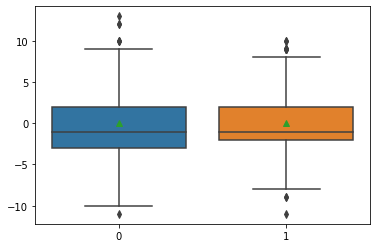

In [97]:
lr.fit(ooo_h_variables, df[target])
predictions['OOO_TRUE_H'] = np.round(df['OOO_H_RATE'] * (season_pa - predictions['TRUE_BB'] - predictions['OOO_TRUE_K'] - predictions['OOO_TRUE_HR']), 0).astype('int')
predictions['OOO_PRED_H'] = np.round(lr.predict(ooo_h_variables) * (season_pa - predictions['PRED_BB'] - predictions['OOO_PRED_K'] - predictions['OOO_PRED_HR']), 0).astype('int')

sns.boxplot(
    data=[predictions['PRED_H'] - predictions['TRUE_H'], predictions['OOO_PRED_H'] - predictions['OOO_TRUE_H']],
    showmeans=True
)
plt.show()

In [99]:
print(mean_squared_error(predictions['OOO_PRED_H'], predictions['OOO_TRUE_H']))
print(mean_squared_error(predictions['PRED_H'], predictions['TRUE_H']))

print(r2_score(predictions['OOO_PRED_H'], predictions['OOO_TRUE_H']))
print(r2_score(predictions['PRED_H'], predictions['TRUE_H']))

14.836501901140684
18.41444866920152
0.9660083971904608
0.9355449111202131


The order of operations method appears to be slightly better at predicting the total number of hits compared to the per plate apperance method. Does that hold true when hits are added to the predicted number of homeruns, to get an accurate comparision between the two?

When adding predicted home runs to the order of operations hit predictions, that method still comes out slightly ahead in both metrics.

In [100]:
ooo_pred_hits = predictions['OOO_PRED_H'] + predictions['OOO_PRED_HR']
ooo_true_hits = predictions['OOO_TRUE_H'] + predictions['OOO_TRUE_HR']

print(mean_squared_error(ooo_pred_hits, ooo_true_hits))
print(r2_score(ooo_pred_hits, ooo_true_hits))

print(mean_squared_error(predictions['PRED_H'], predictions['TRUE_H']))
print(r2_score(predictions['PRED_H'], predictions['TRUE_H']))

16.072243346007603
0.9444645820030639
18.41444866920152
0.9355449111202131


##### Extra Base Hits 
There's going to be a slightly different prediction that takes place for each method here, but they'll meetup after predicting triples. 

For the plate appearance method, the number of doubles will be predicted. For the order of operations method, the total number of extra base hits will be predicted based on the total number of hits for the player. Order of operations state that extra base hits are determined after a hit occurs.

By now we're in a rhythm, so I'll blow through the next couple of code blocks. For method two, there doesn't appear to be any "breaks" with gap, and all variables are selected in the feature elimination process. So a full model is fitted and then a season's doubles for each rate is predicted. 

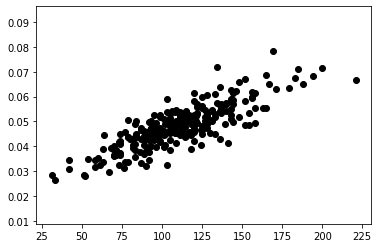

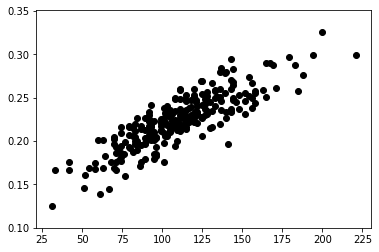

In [131]:
df['DOUBLE_RATE'] = df['2B'] / df['PA']
df['OOO_XBH_RATE'] = (df['2B'] + df['3B']) / (df['H'])

plt.scatter(df['batting_ratings_vsr_gap'], df['DOUBLE_RATE'], color='black')
plt.show()

plt.scatter(df['batting_ratings_vsr_gap'], df['OOO_XBH_RATE'], color='black')
plt.show()

In [132]:
target = 'DOUBLE_RATE'

scores = cross_validate(lr, variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.8760494858594035
-0.00000901


In [133]:
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': True,
 'batting_ratings_vsr_babip': True,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

0.0038022813688212928


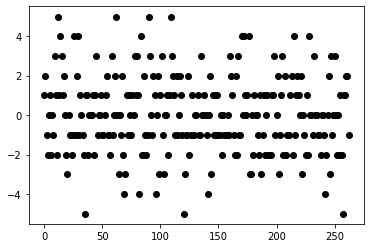

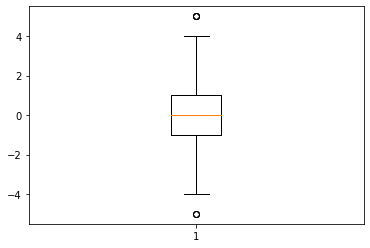

In [134]:
lr.fit(variables, df[target])
predictions['TRUE_DOUBLES'] = np.round(df['DOUBLE_RATE'] * season_pa, 0).astype('int')
predictions['PRED_DOUBLES'] = np.round(lr.predict(variables) * season_pa, 0).astype('int')

print(abs(np.mean(predictions['PRED_DOUBLES'] - predictions['TRUE_DOUBLES'])))
plt.scatter(predictions.reset_index().index, predictions['PRED_DOUBLES'] - predictions['TRUE_DOUBLES'], color='black')
plt.show()

plt.boxplot(predictions['PRED_DOUBLES'] - predictions['TRUE_DOUBLES'])
plt.show()

With this method, most players are within +/- a single double over the course of a season.

Moving onto the order of operations method. A player's eye rating is the only variable eliminated, so a separate variable set is then created, and then the total number of XBHs are predicted based on the predicted number of hits from the previous step.

In [135]:
target = 'OOO_XBH_RATE'

selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': True,
 'batting_ratings_vsr_babip': True,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': False,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

In [136]:
ooo_xbh_variables = variables.loc[:, ['running_ratings_speed',
                                    'batting_ratings_vsr_babip',
                                    'batting_ratings_vsr_gap',
                                    'batting_ratings_vsr_power',
                                    'batting_ratings_vsr_strikeouts',
                                    'batting_ratings_misc_gb_hitter_type_0',
                                    'batting_ratings_misc_gb_hitter_type_1',
                                    'batting_ratings_misc_gb_hitter_type_2',
                                    'batting_ratings_misc_gb_hitter_type_3',
                                    'batting_ratings_misc_fb_hitter_type_0',
                                    'batting_ratings_misc_fb_hitter_type_1',
                                    'batting_ratings_misc_fb_hitter_type_2',
                                    'bats_1',
                                    'bats_2']]



scores = cross_validate(lr, ooo_xbh_variables, df[target], cv=splitter, scoring=('r2', 'neg_mean_squared_error'))
print(np.mean(scores['test_r2']))
print('{:.8f}'.format(float(np.mean(scores['test_neg_mean_squared_error']))))

0.9295396922416383
-0.00006273


0.015209125475285171


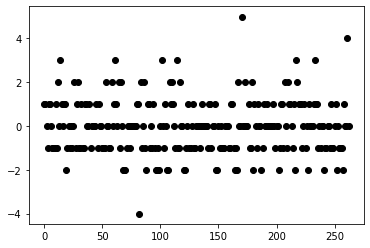

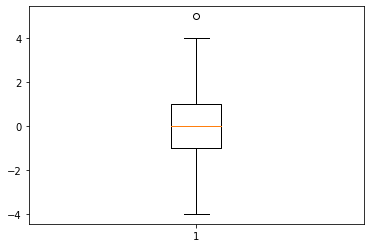

In [137]:
lr.fit(ooo_xbh_variables, df[target])

predictions['OOO_TRUE_XBH'] = np.round(df['OOO_XBH_RATE'] * predictions['OOO_TRUE_H'], 0).astype('int')
predictions['OOO_PRED_XBH'] = np.round(lr.predict(ooo_xbh_variables) * predictions['OOO_PRED_H'], 0).astype('int')

print(abs(np.mean(predictions['OOO_PRED_XBH'] - predictions['OOO_TRUE_XBH'])))
plt.scatter(predictions.reset_index().index, predictions['OOO_PRED_XBH'] - predictions['OOO_TRUE_XBH'], color='black')
plt.show()

plt.boxplot(predictions['OOO_PRED_XBH'] - predictions['OOO_TRUE_XBH'])
plt.show()

##### Triples
After this step is completed, the two methods converge again. 

Again, a straightforward process, looking at breakpoints for both methods, this time comparing speed. Then moving through the feature selection process, and then fitting the model on the subset of features identified.

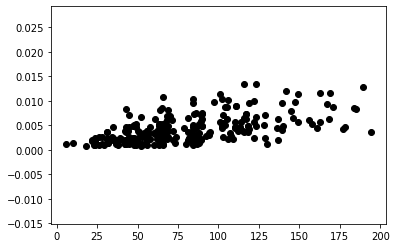

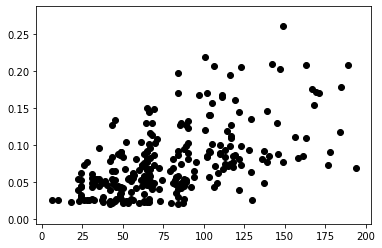

In [138]:
df['TRIPLE_RATE'] =  df['3B'] / df['PA']
df['OOO_TRIPLE_RATE'] =  df['3B'] / (df['2B'] + df['3B'])

plt.scatter(df['running_ratings_speed'], df['TRIPLE_RATE'], color='black')
plt.show()

plt.scatter(df['running_ratings_speed'], df['OOO_TRIPLE_RATE'], color='black')
plt.show()

In [139]:
target = 'TRIPLE_RATE'

selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': True,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': True,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': False,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

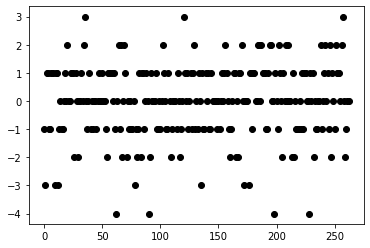

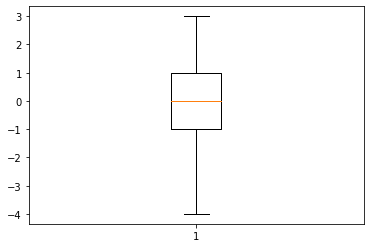

In [140]:
triple_variables = variables.loc[:, ['running_ratings_speed',
                    'batting_ratings_vsr_gap',
                    'batting_ratings_vsr_power',
                    'batting_ratings_vsr_eye',
                    'batting_ratings_vsr_strikeouts',
                    'batting_ratings_misc_gb_hitter_type_0',
                    'batting_ratings_misc_gb_hitter_type_1',
                    'batting_ratings_misc_gb_hitter_type_2',
                    'batting_ratings_misc_gb_hitter_type_3',
                    'batting_ratings_misc_fb_hitter_type_0',
                    'batting_ratings_misc_fb_hitter_type_1',
                    'batting_ratings_misc_fb_hitter_type_2',
                    'bats_1',
                    'bats_2'  
                    ]]

lr.fit(triple_variables, df[target])



predictions['TRUE_TRIPLE'] = np.round(df['TRIPLE_RATE'] * season_pa, 0).astype('int')
predictions['PRED_TRIPLE'] = np.round(lr.predict(triple_variables) * season_pa, 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['PRED_TRIPLE'] - predictions['TRUE_TRIPLE'], color='black')
plt.show()

plt.boxplot(predictions['PRED_TRIPLE'] - predictions['TRUE_TRIPLE'])
plt.show()

In [141]:
target = 'OOO_TRIPLE_RATE'
selector.fit(variables, df[target])
dict(zip(variables.columns, selector.support_))

{'running_ratings_speed': True,
 'batting_ratings_vsr_babip': False,
 'batting_ratings_vsr_gap': True,
 'batting_ratings_vsr_power': True,
 'batting_ratings_vsr_eye': False,
 'batting_ratings_vsr_strikeouts': True,
 'batting_ratings_misc_gb_hitter_type_0': True,
 'batting_ratings_misc_gb_hitter_type_1': True,
 'batting_ratings_misc_gb_hitter_type_2': True,
 'batting_ratings_misc_gb_hitter_type_3': True,
 'batting_ratings_misc_fb_hitter_type_0': True,
 'batting_ratings_misc_fb_hitter_type_1': True,
 'batting_ratings_misc_fb_hitter_type_2': True,
 'bats_1': True,
 'bats_2': True}

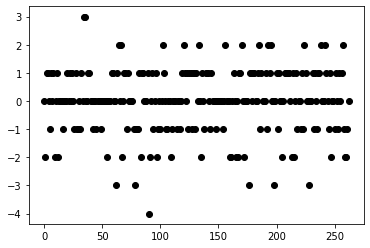

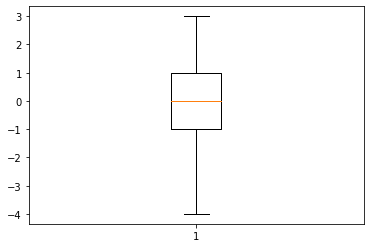

In [142]:
ooo_triple_variables = variables.loc[:, ['running_ratings_speed',
                    'batting_ratings_vsr_gap',
                    'batting_ratings_vsr_power',
                    'batting_ratings_vsr_strikeouts',
                    'batting_ratings_misc_gb_hitter_type_0',
                    'batting_ratings_misc_gb_hitter_type_1',
                    'batting_ratings_misc_gb_hitter_type_2',
                    'batting_ratings_misc_gb_hitter_type_3',
                    'batting_ratings_misc_fb_hitter_type_0',
                    'batting_ratings_misc_fb_hitter_type_1',
                    'batting_ratings_misc_fb_hitter_type_2',
                    'bats_1',
                    'bats_2'  
                    ]]

lr.fit(ooo_triple_variables, df[target])

predictions['OOO_TRUE_TRIPLE'] = np.round(df['OOO_TRIPLE_RATE'] * predictions['OOO_TRUE_XBH'], 0).astype('int')
predictions['OOO_PRED_TRIPLE'] = np.round(lr.predict(ooo_triple_variables) * predictions['OOO_PRED_XBH'], 0).astype('int')

plt.scatter(predictions.reset_index().index, predictions['OOO_PRED_TRIPLE'] - predictions['OOO_TRUE_TRIPLE'], color='black')
plt.show()

plt.boxplot(predictions['OOO_PRED_TRIPLE'] - predictions['OOO_TRUE_TRIPLE'])
plt.show()

With triples predicted for both methods, we can then compare how well the two methods shake out against each other.

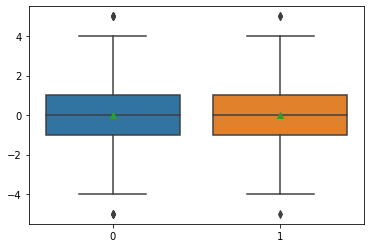

In [143]:
ooo_true_doubles = predictions['OOO_TRUE_XBH'] - predictions['OOO_TRUE_TRIPLE']
ooo_pred_doubles = predictions['OOO_PRED_XBH'] - predictions['OOO_PRED_TRIPLE']

sns.boxplot(
    data=[predictions['PRED_DOUBLES'] - predictions['TRUE_DOUBLES'], ooo_pred_doubles - ooo_true_doubles],
    showmeans=True
)
plt.show()

In [144]:
print(mean_squared_error(ooo_pred_doubles, ooo_true_doubles))
print(r2_score(ooo_pred_doubles, ooo_true_doubles))

print(mean_squared_error(predictions['PRED_DOUBLES'], predictions['TRUE_DOUBLES']))
print(r2_score(predictions['PRED_DOUBLES'], predictions['TRUE_DOUBLES']))

3.2623574144486693
0.9101020909807284
3.821292775665399
0.8815206984099662


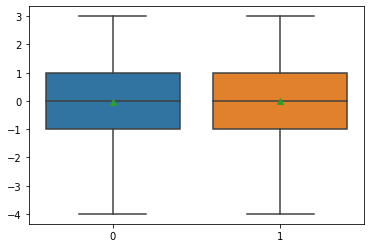

In [146]:
sns.boxplot(
    data=[predictions['PRED_TRIPLE'] - predictions['TRUE_TRIPLE'], predictions['OOO_PRED_TRIPLE'] - predictions['OOO_TRUE_TRIPLE']],
    showmeans=True
)
plt.show()

In [147]:
print(mean_squared_error(predictions['OOO_PRED_TRIPLE'], predictions['OOO_TRUE_TRIPLE']))
print(r2_score(predictions['OOO_PRED_TRIPLE'], predictions['OOO_TRUE_TRIPLE']))

print(mean_squared_error(predictions['PRED_TRIPLE'], predictions['TRUE_TRIPLE']))
print(r2_score(predictions['PRED_TRIPLE'], predictions['TRUE_TRIPLE']))

1.2547528517110267
0.30319379546220915
1.6806083650190113
0.16885215426634848


Both order of operations methods appear to be slightly better, when looking at mean squared error and r2, at predicting extra base hits. Is it something significantly better? Perhaps not because over the course of a season there's really no difference.

#### Putting it all together with wOBA
We're not at the end of both methods two and three, having created models for every event that makes up the components in wOBA, at least the ones that are readily available through the simulation module.

These next two code blocks just copy of the predicted wOBA from method one, along with the player's actual wOBA from the simulation model into our predictions dataframe for ease of use. Also a function to calculate wOBA is created so we can easily pass the various events to it.

In [148]:
predictions['PRED_WOBA'] = df['PRED_WOBA']
predictions['ACTUAL_WOBA'] = df['wOBA']

In [149]:
def calc_woba(walks, singles, doubles, triples, homeruns, pa):
    bb_coef = .69 * walks
    singles_coef = .89 * singles
    doubles_coef = 1.27 * doubles
    triples_coef = 1.62 * triples
    homerun_coef = 2.10 * homeruns
    
    woba = (bb_coef + singles_coef + doubles_coef + triples_coef + homerun_coef) / pa
    return woba

Again, those coefficients in the function above come from [this Fangraphs article](https://library.fangraphs.com/offense/woba/), and were used when calculating wOBA from the simuatlion module reports.

For method two we have all the component statistics outside of singles from our various models. We'll get singles for method two based on the predicted hits, and then subtracting doubles, triples and home runs from it.

In [150]:
predictions['PRED_1B'] = predictions['PRED_H'] - predictions['PRED_DOUBLE_RATE'] - predictions['PRED_TRIPLE'] - predictions['PRED_HR']

In [153]:
predictions[['PRED_BB', 'PRED_H', 'PRED_1B', 'PRED_DOUBLES', 'PRED_TRIPLE', 'PRED_HR']]

,PRED_BB,PRED_H,PRED_1B,PRED_DOUBLES,PRED_TRIPLE,PRED_HR
player_id,,,,,,
12,92,121,60,22,1,38
15,53,182,112,40,5,25
16,93,159,96,30,2,31
28,77,161,106,32,2,21
42,54,125,80,24,1,20
...,...,...,...,...,...,...
36418,48,144,105,27,3,9
36517,54,171,104,40,3,24
36568,59,170,110,36,2,22


Let's throw the predictions at the wOBA function.

In [154]:
predictions['CALC_WOBA'] = calc_woba(predictions['PRED_BB'],
                                     predictions['PRED_1B'],
                                     predictions['PRED_DOUBLES']
                                     , predictions['PRED_TRIPLE'],
                                     predictions['PRED_HR'],
                                     season_pa)

With the order of opeations method, we have to also calculate the number of singles, along with the number of doubles. For singles, we just have to subtract extra base hits from the predicted hits, since home runs were already removed. To get the total number of doubles, we just subtract triples from our prediced extra base hits.

In [155]:
predictions['OOO_PRED_1B'] = predictions['OOO_PRED_H'] - predictions['OOO_PRED_XBH']
predictions['OOO_PRED_2B'] = predictions['OOO_PRED_XBH'] - predictions['OOO_PRED_TRIPLE']

predictions['OOO_CALC_WOBA'] = calc_woba(predictions['PRED_BB'],
                                     predictions['OOO_PRED_1B'],
                                     predictions['OOO_PRED_2B']
                                     , predictions['OOO_PRED_TRIPLE'],
                                     predictions['OOO_PRED_HR'],
                                     season_pa)

Before getting into the various metrics used to compare methods, let's take a look at how the various methods stack up with each other.

In [156]:
predictions[['ACTUAL_WOBA', 'PRED_WOBA', 'CALC_WOBA', 'OOO_CALC_WOBA']]

,ACTUAL_WOBA,PRED_WOBA,CALC_WOBA,OOO_CALC_WOBA
player_id,,,,
12,0.3307,0.326664,0.332706,0.332809
15,0.3701,0.364708,0.364191,0.364015
16,0.3677,0.372252,0.376544,0.371882
28,0.3537,0.348109,0.346250,0.345794
42,0.2712,0.273863,0.268471,0.269412
...,...,...,...,...
36418,0.2751,0.270499,0.271500,0.269868
36517,0.3541,0.351612,0.346882,0.345632
36568,0.3452,0.349421,0.343779,0.340471


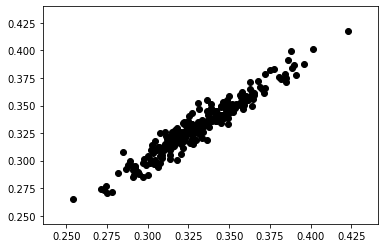

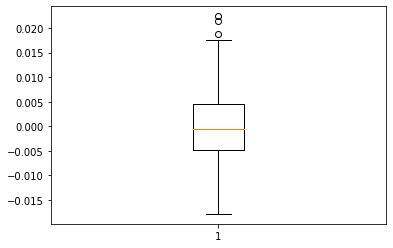

5.076047017346677e-05
0.9230390964244771


In [171]:
plt.scatter(predictions['ACTUAL_WOBA'], predictions['PRED_WOBA'], color='black')
plt.show()

plt.boxplot(predictions['PRED_WOBA'] - predictions['ACTUAL_WOBA'])
plt.show()

print(mean_squared_error(predictions['ACTUAL_WOBA'], predictions['PRED_WOBA']))
print(r2_score(predictions['ACTUAL_WOBA'], predictions['PRED_WOBA']))

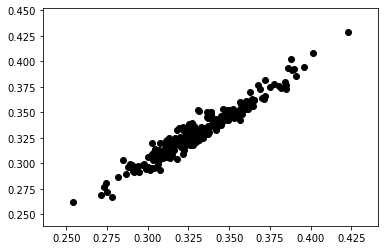

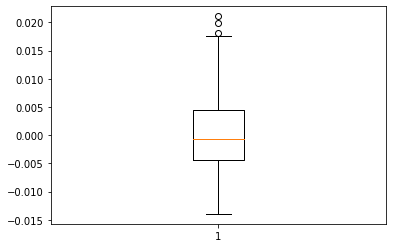

4.2134062520557315e-05
0.9361180952065993


In [169]:
plt.scatter(predictions['ACTUAL_WOBA'], predictions['CALC_WOBA'], color='black')
plt.show()

plt.boxplot(predictions['CALC_WOBA'] - predictions['ACTUAL_WOBA'])
plt.show()

print(mean_squared_error(predictions['ACTUAL_WOBA'], predictions['CALC_WOBA']))
print(r2_score(predictions['ACTUAL_WOBA'], predictions['CALC_WOBA']))

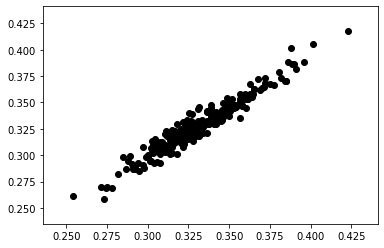

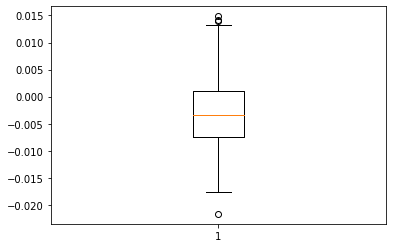

5.1755602148486226e-05
0.9215303189109382


In [170]:
plt.scatter(predictions['ACTUAL_WOBA'], predictions['OOO_CALC_WOBA'], color='black')
plt.show()

plt.boxplot(predictions['OOO_CALC_WOBA'] - predictions['ACTUAL_WOBA'])
plt.show()

print(mean_squared_error(predictions['ACTUAL_WOBA'], predictions['OOO_CALC_WOBA']))
print(r2_score(predictions['ACTUAL_WOBA'], predictions['OOO_CALC_WOBA']))

With all the metrics calculated and printed out, method two appears to have the best mean squared error and r2 score, with the first method of just throwing every variable and using linear regression against the player's wOBA from the simuatlion module coming in second. Third place, and not far off, is the order of operations method. When looking at the boxplots, it appears that the order of operations method will typically underestimate a player's wOBA by up to 10 points typically, whereas the other two methods generally are within +/- 5 points. 

#### One Final Thing
What I set out to do with this notebook is complete. I wanted to look at one thing that was mentioned by someone on the forums and that was the concept of interaction terms. So this is just a bonus section with a quick look at predicting wOBA with all the original variables, with an additional interaction terms.

In [177]:
from sklearn.preprocessing import PolynomialFeatures

target = 'wOBA'
poly = PolynomialFeatures(interaction_only=True)
x = poly.fit_transform(variables)
lr.fit(x, df[target])

array([[  1.,  65.,  83., ...,   0.,   1.,   0.],
       [  1., 169., 134., ...,   1.,   0.,   0.],
       [  1.,  63., 154., ...,   0.,   1.,   0.],
       ...,
       [  1.,  43., 121., ...,   1.,   0.,   0.],
       [  1., 185., 133., ...,   0.,   0.,   0.],
       [  1.,  28., 134., ...,   0.,   1.,   0.]])

In [181]:
print(mean_squared_error(predictions['ACTUAL_WOBA'], predictions['PRED_WOBA']))
print(r2_score(predictions['ACTUAL_WOBA'], predictions['PRED_WOBA']))

5.076047017346677e-05
0.9230390964244771


In [182]:
print(mean_squared_error(lr.predict(x), df[target]))
print(r2_score(lr.predict(x), df[target]))

3.2468342017788394e-05
0.948224075861082


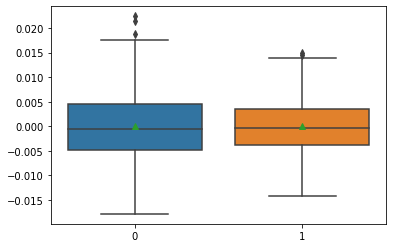

In [183]:
sns.boxplot(
    data=[predictions['PRED_WOBA'] - predictions['ACTUAL_WOBA'], lr.predict(x) -  df[target]],
    showmeans=True
)
plt.show()

So the answer: does using interaction terms produce a better model? It would appear there is something there and more investigation would be us